In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

import random
import scipy.optimize as scop
from fractions import Fraction

from matplotlib.pyplot import figure
from matplotlib.pyplot import  grid

import matplotlib.ticker as ticker



In [41]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [42]:
# Class for converting timestamps between recording systems using sync pulses with 
# random inter-pulse intervals. 
# https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation
# Dependencies:  Python 3, Numpy, Matplotlib, Scikit-learn.
# (c) Thomas Akam 2018. Released under the GPL-3 open source licence.

import numpy as np
import pylab as plt
from sklearn.mixture import GaussianMixture

class RsyncError(Exception):
    pass

class Rsync_aligner():

    def __init__(self, pulse_times_A, pulse_times_B, units_A=1, units_B=1, 
                 chunk_size=5, plot=False, raise_exception=True):
        '''Class for converting timestamps between two recording systems
        (e.g  pyControl and an ephys) using sync pulses with random inter-pulse
        intervals recorded on both systems.  Typically these sync pulses are generated
        by pyControl using the Rsync hardware object and sent to other systems. To use the
        Rsync_aligner,instantiate it by providing the sync pulse times recorded by each
        system. Timestamps from either system can then be converted into the reference frame
        of the other using the A_to_B and B_to_A methods.  If the hardware systems use 
        different units to measure time this must be specified using the units arguments
        when the aligner is instantiated. When the aligner is instantiated it works out 
        which pulses in each reference frame correspond to each other by by aligning 
        short chunks of pulse sequence A with B by minimising the mean squared error 
        between inter-pulse intervals.
        Arguments:
        pulse_times_A: The times when sync pulses occured recorded by hardware system A.
        pulse_times_B: The times when sync pulses occured recorded by hardware system B.
        units_A: The time units used by system A expressed in milliseconds.  E.g. if 
                 system A uses units of seconds the *units_A* argument is 1000.  
        units_B: The time units used by system B expressed in milliseconds.
        plot: Whether to plot information about the alignment.
        raise_exception: If *True* an RsyncError exception is raised if no match is found
                         between the sync pulse sequences.
        '''

        # Convert all units to ms.
        pulse_times_A = pulse_times_A*units_A
        pulse_times_B = pulse_times_B*units_B
        # Evalute inter pulse intervals
        intervals_A = np.diff(pulse_times_A) # Inter-pulse intervals for sequence A
        intervals_B = np.diff(pulse_times_B) # Inter-pulse intervals for sequence B
        intervals_B2 = intervals_B**2
        # Find alignments of chunks which minimise sum of squared errors.
        chunk_starts_A = np.arange(0, len(pulse_times_A)-chunk_size, chunk_size) # Start indices of each chunk of sequence A.
        chunk_starts_B = np.zeros(chunk_starts_A.shape, int)                     # Start indicies of corresponding chunks in B.
        chunk_min_mse = np.zeros(chunk_starts_A.shape) # Mean squared error for each chunks best alignment.
        chunk_2nd_mse = np.zeros(chunk_starts_A.shape) # Mean sqared error for each chunks second best (i.e non matching) alignment.
        ones_chunk = np.ones(chunk_size)
        for i, csA in enumerate(chunk_starts_A):
            chunk_A = intervals_A[csA:csA+chunk_size]
            mse = (  np.correlate(intervals_B2, ones_chunk, mode='valid') + np.sum(chunk_A**2) -
                   2*np.correlate(intervals_B , chunk_A   , mode='valid')) / chunk_size
            chunk_starts_B[i]  = np.argmin(mse)
            sorted_chunk_min_mse = np.sort(mse)
            chunk_min_mse[i] = sorted_chunk_min_mse[0]
            chunk_2nd_mse[i] = sorted_chunk_min_mse[1]
        # Assign chunks to matched and non-matched groups by fitting 2 component
        # Gaussian mixture model to log mse distribition of best + second best 
        # alignments.
        chunk_mse = np.hstack([chunk_min_mse,chunk_2nd_mse]) 
        chunk_mse[chunk_mse == 0] = np.min(chunk_mse[chunk_mse != 0]) # Replace zeros with smallest non zero value.
        log_mse = np.log(chunk_mse)
        log_mse = log_mse[np.isfinite(log_mse)].reshape(-1,1)
        gmm = GaussianMixture(n_components=2, covariance_type='spherical')
        gmm.fit(log_mse)
        valid_matches = gmm.predict(log_mse) == np.argmin(gmm.means_) # True for chunks which are valid matches.
        # Make arrays of corresponding times.
        cor_times_A = np.full(pulse_times_B.shape, np.nan) # A pulse times corresponding to each B pulse.
        cor_times_B = np.full(pulse_times_A.shape, np.nan) # B pulse times corresponding to each A pulse.
        for csA, csB, valid in zip(chunk_starts_A, chunk_starts_B, valid_matches):
            if valid:
                cor_times_A[csB:csB+chunk_size] = pulse_times_A[csA:csA+chunk_size]
                cor_times_B[csA:csA+chunk_size] = pulse_times_B[csB:csB+chunk_size]
        # Store pulse times, their correspondences and units.
        self.pulse_times_A = pulse_times_A
        self.pulse_times_B = pulse_times_B
        self.cor_times_A = cor_times_A
        self.cor_times_B = cor_times_B
        self.units_A = units_A
        self.units_B = units_B
        # Check quality of alignment.
        separation_OK = (np.abs(gmm.means_[0]-gmm.means_[1])[0] >  # Different in GMM means > 3 x sum of standard deviations.
                         3*np.sum(np.sqrt(gmm.covariances_)))
        order_OK = ((np.nanmin(np.diff(cor_times_A)) > 0) and
                    (np.nanmin(np.diff(cor_times_A)) > 0)) # Corresponding times are monotonically increacing.
        if not (separation_OK and order_OK):
            if raise_exception:
                raise RsyncError('No match found between inter-pulse interval sequences.')
            else:
                print('Rsync warning: No match found between inter-pulse interval sequences.')
        # Plotting
        if plot:
            plt.figure(plot if type(plot)==int else 1, figsize=[7,9]).clf()
            plt.subplot2grid((3,3),(0,0),rowspan=1,colspan=2)
            plt.hist(log_mse[ valid_matches], 20, color='b', label='Match')
            plt.hist(log_mse[~valid_matches], 20, color='r', label='Non-match')
            plt.legend(loc='upper center')
            plt.xlabel('Log mean squared error')
            plt.ylabel('# chunks')
            plt.subplot2grid((3,3),(0,2),rowspan=1,colspan=1)
            timing_errors = np.diff(cor_times_A) - np.diff(pulse_times_B)
            plt.hist(timing_errors[~np.isnan(timing_errors)],100)
            plt.yscale('log', nonposy='clip')
            plt.xlabel('Inter-pulse interval\ndiscrepancy (ms)')
            plt.ylabel('# pulses')
            plt.subplot2grid((3,1),(1,0),rowspan=2,colspan=1)
            plt.plot(pulse_times_A/units_A, cor_times_B/units_B , '.', markersize=2)  
            plt.xlim(pulse_times_A[0]/units_A,pulse_times_A[-1]/units_A)
            plt.xlabel('pulse times A')
            plt.ylabel('pulse times B')
            plt.tight_layout()

    def A_to_B(self, times_A):
        '''Convert times in A reference frame to B reference frame.'''
        return np.interp(times_A*self.units_A, self.pulse_times_A, self.cor_times_B,
                         left=np.nan, right=np.nan)/self.units_B

    def B_to_A(self, times_B):
        '''Convert times in B reference frame to A reference frame.'''
        return np.interp(times_B*self.units_B, self.pulse_times_B, self.cor_times_A,
                         left=np.nan, right=np.nan)/self.units_A

# --------------------------------------------------------------------------

def simulate_pulses(n_pulse=1000,interval=[100,1900], noise_SD=3, missing_pulses=False):
    ''' Simulate a pair of pulse trains timestamps with drift between their timings.'''
    pulse_times_A = np.cumsum(np.random.randint(*interval, size=n_pulse)).astype(float)
    pulse_times_B = pulse_times_A + np.cumsum(np.random.normal(scale=noise_SD, size=n_pulse))
    if missing_pulses:

        pulse_times_A = np.hstack([pulse_times_A[int(n_pulse*0.05):int(n_pulse*0.21)],pulse_times_A[int(n_pulse*0.33):]])
        pulse_times_B = np.hstack([pulse_times_B[:int(n_pulse*0.74)],pulse_times_B[int(n_pulse*0.85):int(n_pulse*0.95)]])
    return pulse_times_A, pulse_times_B


In [43]:
figure_path = '/Users/joshuakeeling/Documents/Python/Project/Figures'

def save_figure(name, base_path=figure_path):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.png'), 
                bbox_inches='tight', transparent=True)

#  Helper functions

In [44]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [45]:
def get_transitions_state(graph_type):
    
    transitions = [[i,i+1] for i in range(8)]
    transitions.extend([[i,i-1] for i in range(1,9)])
    if graph_type=='loop':
        transitions.extend([[0,8],[8,0]])
        
    all_transitions = []
    for kk, pk in enumerate(transitions):
        all_transitions.append(str(pk[0])+'_'+str(pk[1]))
    return all_transitions

In [46]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        cmap_ = 'RdBu_r'
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=np.max(spks),clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            G.add_node(i,pos=poke_pos[i],color=cmap.to_rgba(c))
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    #print(all_transitions)
    for e in all_transitions:
        #print(all_transitions)
        G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=1
        )
    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=1)


In [47]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            #print(poke,target)
            if poke==target:
                #print(poke)
                if poke in poke_dict.keys():
                    poke_dict[poke].append(t_)
                else:
                    poke_dict[poke] = [t_]
                #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

# Actual code

In [48]:
#load behavioural data
task_path = '/Users/joshuakeeling/Dropbox/example_files/39951-2021-08-05-140214.txt'
lines = open(task_path,'r').readlines()


#load neural data timestamps
sync_path_spk = '/Users/joshuakeeling/Dropbox/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
ROOT = '/Users/joshuakeeling/Dropbox/example_files/'
spkT = np.load(os.path.join(ROOT,'spike_times.npy')).flatten()
spkC = np.load(os.path.join(ROOT,'spike_clusters.npy')).flatten()
cluster_labels = pd.read_table(os.path.join(ROOT,'cluster_KSLabel.tsv'))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [49]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [50]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [51]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

P 1 graph_type:line
 dict_keys(['task_nr', 'seq'])
P 458721 graph_type:line
 dict_keys(['task_nr', 'seq'])
P 985825 graph_type:line
 dict_keys(['task_nr', 'seq'])
P 1260086 graph_type:line
 dict_keys(['task_nr', 'seq'])


In [52]:
all_poke_dict[0].keys()

dict_keys(['task_nr', 'seq', 'graph_type', '1', '6', '3', '4', '0', '7', '2', '5', '8'])

In [53]:
def get_all_resps(aligner,poke_dict,single_units,spkT,spkC,window0=3000,window1=6000):
    """ This code gets the average response of all cells to pokes in a single task block
    """
    all_resps = []
    all_resps1 = []
    all_resps2 = []
    
    for unit in single_units:#[n_:n_+1]:  #loop over all cells
        
        spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
        
        resps = [0]*9
        resps1 = [0]*9
        resps2 = [0]*9
        for key,vals in poke_dict.items():  #loop over pokes ?? loop over ports ??
            if re.findall('[0-9]',key): #ignore dictionary items that are metadata like the sequence and graph time
                aligned_T = aligner.B_to_A(vals) #align pokes into spike times

                #get the spikes that are in bounds for position encoding
                pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
                
                used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
                key = int(key)
                half_npks = int(len(used_pks)/2)
                
                for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                    
                    #this is a block of code to split the data in half, useful for looking at stability when you
                    #only have one task block
                    if pk_ix<=half_npks:
                        resps2[key] += float(len(np.where(np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1)))[0]))
                    else:
                        resps1[key] += float(len(np.where(np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1)))[0]))

                    #here store all data
                    resps[key]+= float(len(np.where(np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1)))[0]))
                    
                    ixs2 = np.where(np.logical_and(spk_unit>(tpk-1000),spk_unit<(tpk+30000)))[0]

                resps[key] = 10*resps[key]/float((len(used_pks)))
                resps1[key] = 10*resps1[key]/float(half_npks)
                resps2[key] = 10*resps2[key]/float(len(used_pks)-half_npks)
                
            
        all_resps.append(resps.copy())
        all_resps1.append(resps1.copy())
        all_resps2.append(resps2.copy())
        
    return np.array(all_resps), [np.array(all_resps1),np.array(all_resps2)]

In [54]:
session = 0
comp_session = 2 #comparison session
graph_type = all_poke_dict[session]['graph_type']

all_resps_g1, (all_resps1_g1,all_resps2_g1) = get_all_resps(aligner,all_poke_dict[session],single_units,spkT,spkC)
all_resps_g2, (all_resps1_g2,all_resps2_g2) = get_all_resps(aligner,all_poke_dict[comp_session],single_units,spkT,spkC)

#measure of stability across the session by computing the corr-coef of first half and second half
ccs = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g2):
    ccs.append(np.corrcoef(r1,r2)[0,1])
print(np.nanmean(ccs))

0.559654533203742


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


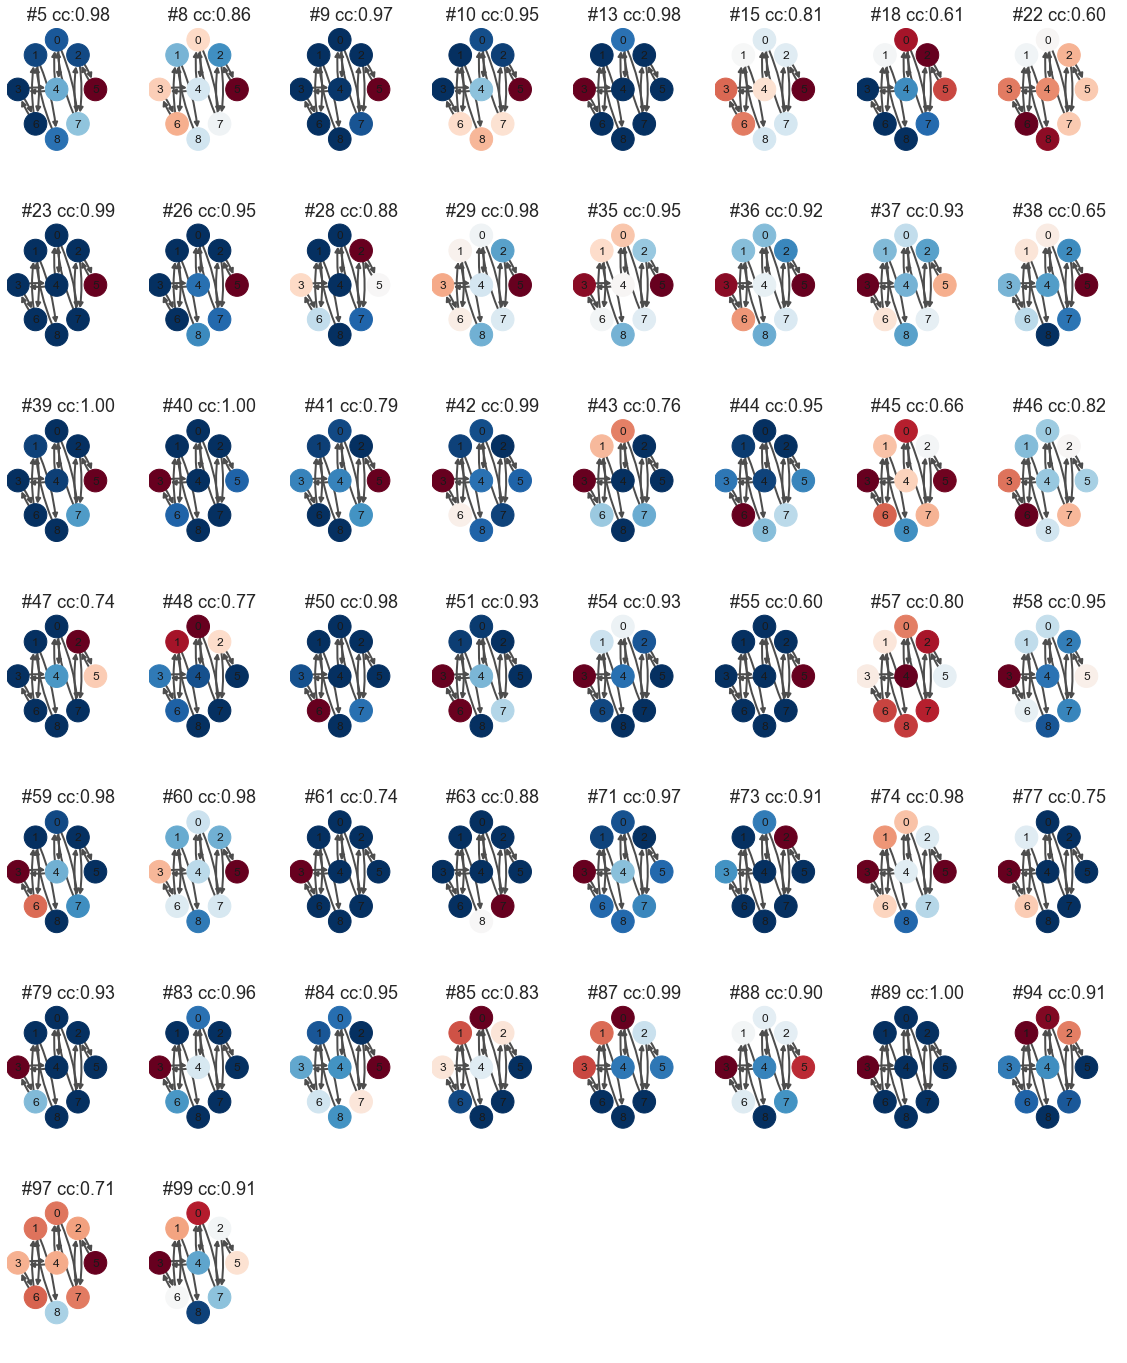

In [55]:
figure(figsize=(16,22))
ctr = 0
for ctr_,spks in enumerate(all_resps1_g1[:100]):
    if ccs[ctr_]>0.5: #only bother plotting if the correlation across parts of session is over 0.5
        plt.subplot(8,8,ctr+1)
        plt.title('#'+str(ctr_) + ' cc:' + '{:.2f}'.format(ccs[ctr_]))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[session]['seq'],graph_type,spks=spks,order='poke',node_size=512)
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1

plt.tight_layout()

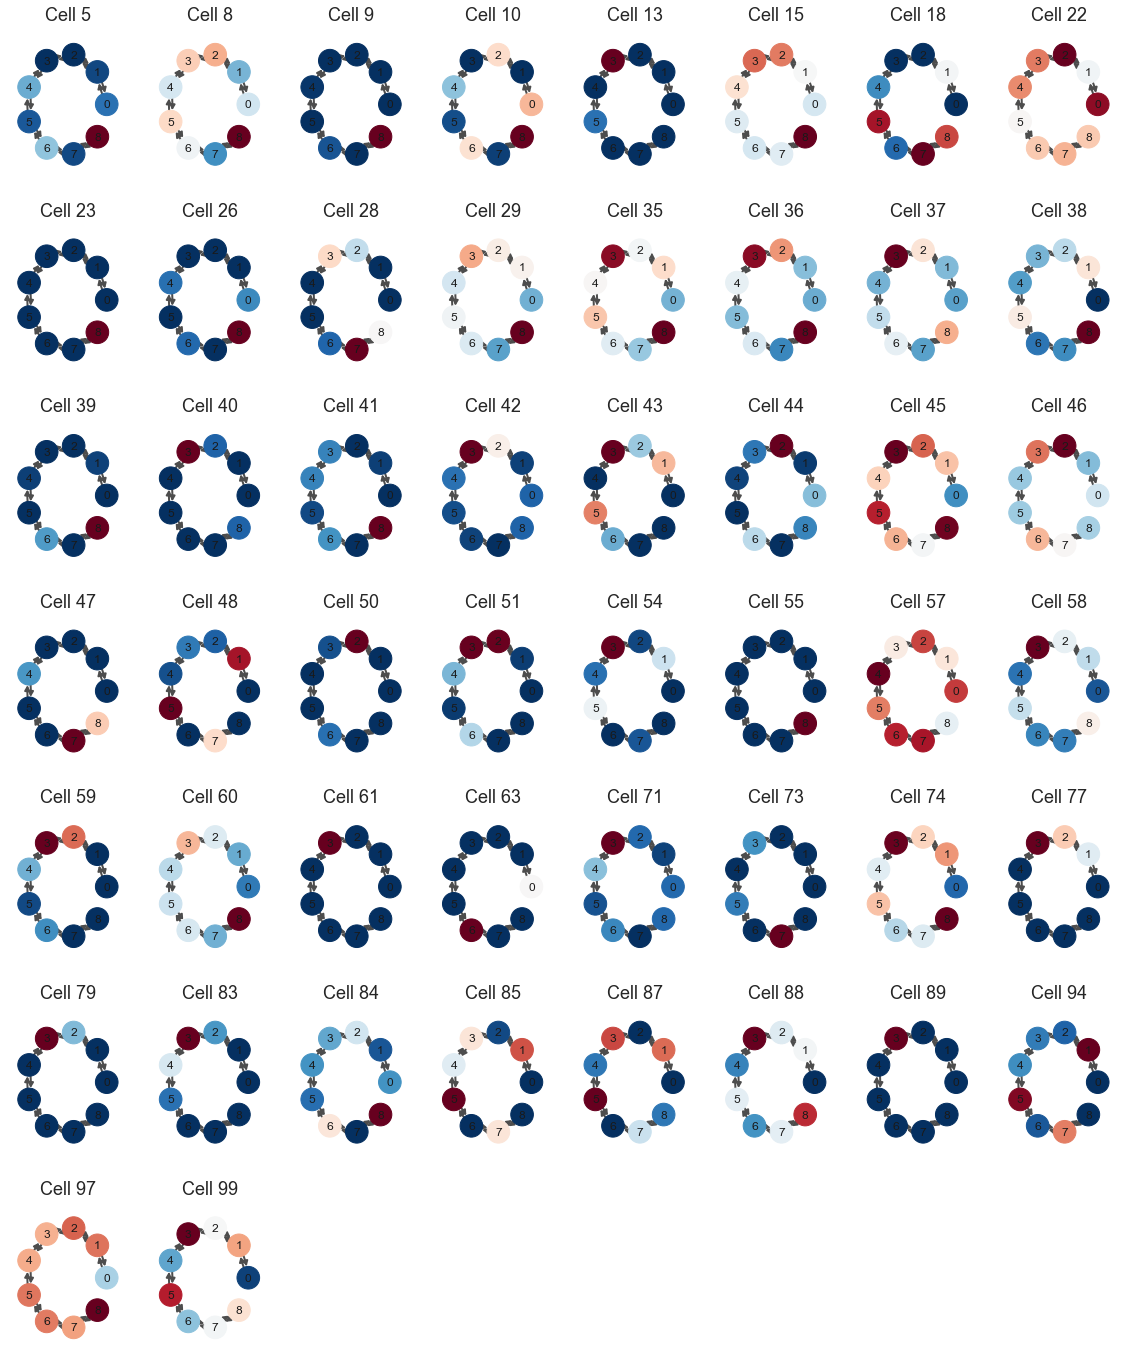

In [67]:

plt.figure(figsize=(16,22))
ctr = 0
resps_state_g1 = all_resps1_g1[:,all_poke_dict[session]['seq']] #reorder into sequence of structure
for ctr_,spks in enumerate(resps_state_g1[:100]):
    if ccs[ctr_]>0.5:
        plt.subplot(8,8,ctr+1)
        plt.title('Cell '+str(ctr_))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[session]['seq'],graph_type,spks=spks,order='state')
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1
save_figure('cells')
plt.tight_layout()

In [57]:
#mean resp  at each port
np.nanmean(resps_state_g1,axis=0)

array([ 7.59375   , 11.49264706, 10.90885417, 14.34791667, 10.16840278,
       12.2125    , 10.075     , 11.14791667, 13.48958333])

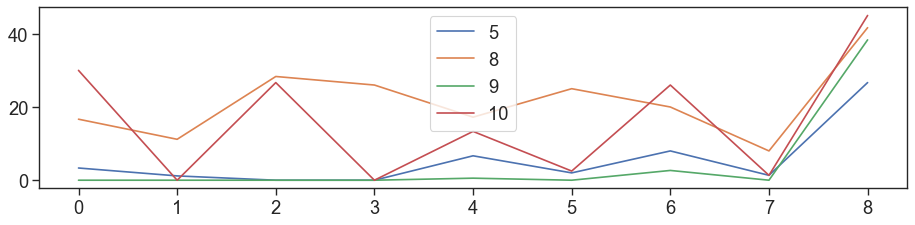

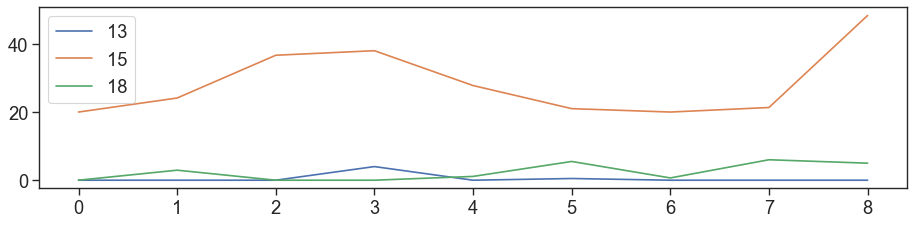

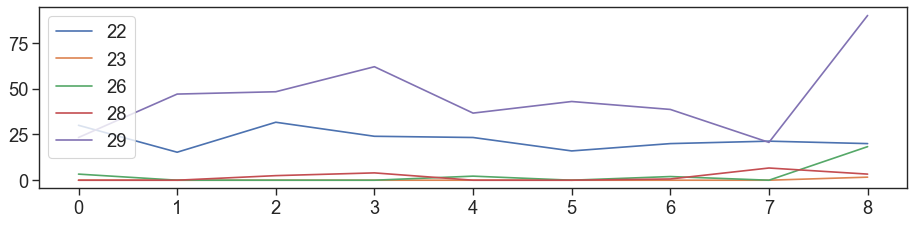

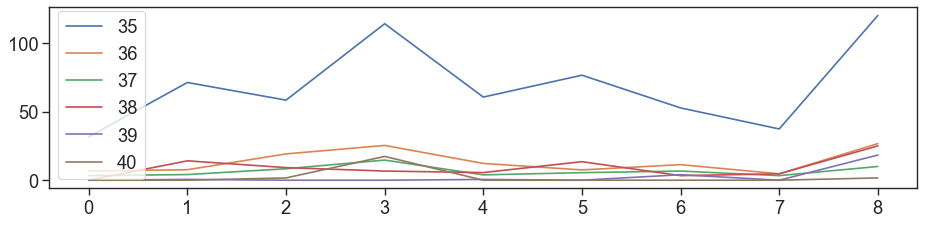

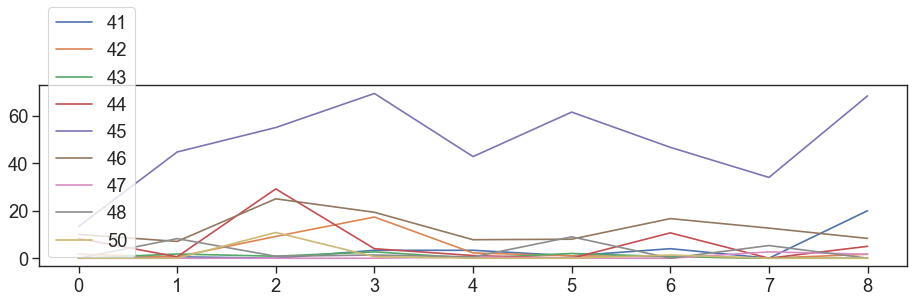

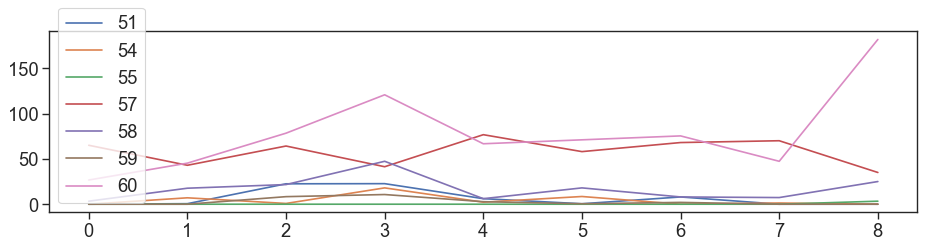

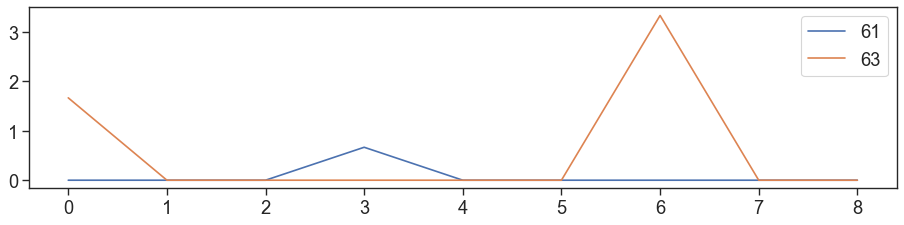

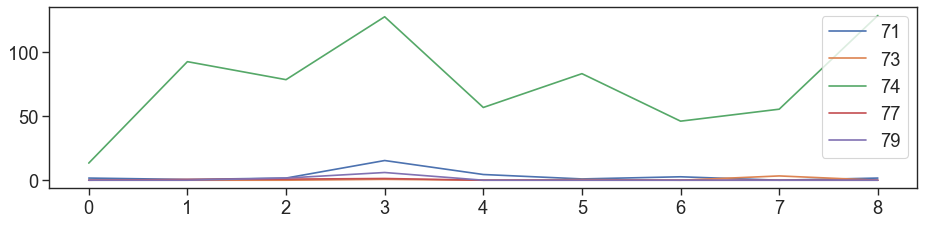

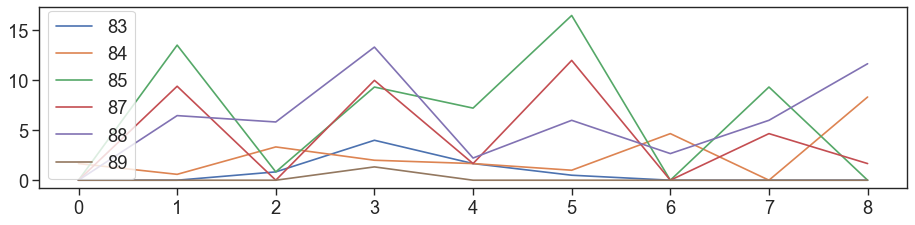

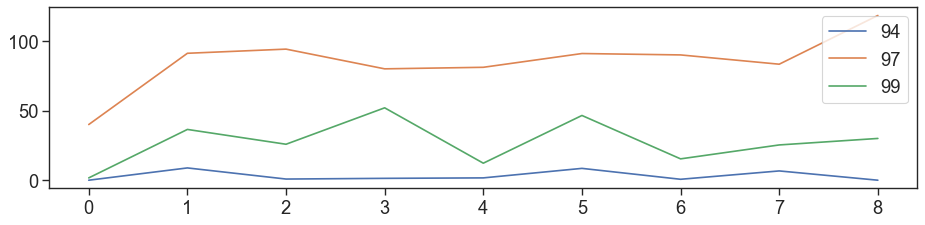

<Figure size 1120x240 with 0 Axes>

In [58]:
##To have a look at groups of cells firing across the 9 states

figure(figsize=(14, 3), dpi=80)

for i in (np.arange(10)*10):
    for ctr_,spks in enumerate(resps_state_g1[:100]):
        if (ctr_>i)&(ctr_ < (i+11)):
            if ccs[ctr_]>0.5:
                plt.plot([0,1,2,3,4,5,6,7,8],np.asarray(resps_state_g1[ctr_]),\
                         label=str(ctr_))
    plt.legend()
    plt.show()

    figure(figsize=(14, 3), dpi=80)


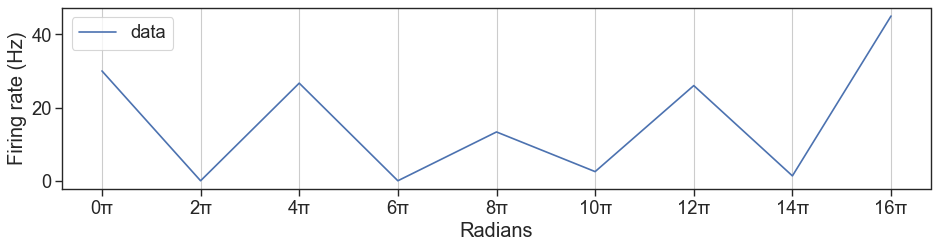

In [59]:
##Show just one of the  cells
# for ctr_,spks in enumerate(resps_state_g1[:100]):
#     if ccs[ctr_]>0.5:

#Settings
cell_number = 10
length = 9

#Get values:
x_values = np.linspace(0,length*np.pi*2,9)
y_values = resps_state_g1[cell_number]

#Get ticks in right place
figure(figsize=(14, 3),dpi=80)
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.FixedLocator(x_values))
pis = []
for i in np.arange((length+1)*2):
    i = str(i*2) +'\u03c0'
    pis.append(i)
ax.xaxis.set_major_formatter(ticker.FixedFormatter((pis)))
ax.xaxis.grid()

#plt.scatter(x_values,y_shuffle,label='shuffle')
plt.plot(x_values,y_values,label='data')

plt.xlabel('Radians')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.show()


In [60]:
##Get RMSE + optimal parameters for specific cell

#Settings

#cell_number = 5
length = 9

#Get values:
x_values = np.linspace(0,length*np.pi*2,9)
y_values = resps_state_g1[cell_number]
# x_values = (np.asarray([0,0.5,1,1.5,2,2.5,3,3.5,4])+x_noise)*4*np.pi
# y_values = np.asarray([0,1,0,-1,0,1,0,-1,0])+y_noise
#Set param options:
x0_options = np.asarray([1,1.5,2,4])/8 #frequency options (number of oscillations along entire structure (18pi))
x1_options = [0,np.pi/2,np.pi,3*np.pi/2] #changes to cos,sine,-sine (assumes no smaller phase shifts allowed)
x2_options = np.linspace(0,np.max((y_values)),10)
x3_options = np.mean(y_values)

param_store = []
cost_fun_store = []


for x0  in x0_options:
    for x1  in  x1_options:
         for x2 in x2_options:
#             for x3 in x3_options:
                x3 = x3_options

                prediction = np.cos(x0 * x_values + x1)* x2 + x3
                rmse = np.mean(((prediction-y_values)**2)**(1/2))
                cost_fun_store.append(rmse)
                param_store.append([x0,x1,x2,x3])

optimal_params = param_store[np.argmin(cost_fun_store)]
optimal_rmse_real = np.min(cost_fun_store)

In [61]:
optimal_params_real

NameError: name 'optimal_params_real' is not defined

In [62]:
optimal_rmse_real

9.241904989898687

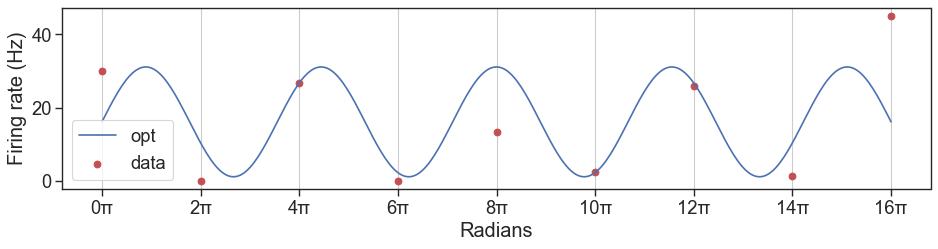

In [63]:
##See the curve you have just found
length=9
#Get ticks in right place
figure(figsize=(14, 3), dpi=80)
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.FixedLocator(x_values))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((pis)))
ax.xaxis.grid()

#plt.scatter(x_values,y_shuffle,label='shuffle')
plt.scatter(x_values,y_values,label='data',color='r')

x_plot = np.linspace(0,(length)*2*np.pi,400)
plt.plot(x_plot,np.cos(optimal_params[0] * x_plot + optimal_params[1])* optimal_params[2]\
         + optimal_params[3],label='opt',color='b')

plt.xlabel('Radians')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.show()



In [64]:
%%time

ovr_score = []

for ctr_,spks in enumerate(resps_state_g1[:100]):
    if ccs[ctr_]>0.5:

        #Settings
        cell_number = ctr_

        #cell_number = 5
        length = 9

        #Get values:
        x_values = np.linspace(0,length*np.pi*2,9)
        y_values = resps_state_g1[cell_number]
        # x_values = (np.asarray([0,0.5,1,1.5,2,2.5,3,3.5,4])+x_noise)*4*np.pi
        # y_values = np.asarray([0,1,0,-1,0,1,0,-1,0])+y_noise
        #Set param options:
        x0_options = np.asarray([1,1.5,2,4])/8 #frequency options (number of oscillations along entire structure (18pi))
        x1_options = [0,np.pi/2,np.pi,3*np.pi/2] #changes to cos,sine,-sine (assumes no smaller phase shifts allowed)
        x2_options = np.linspace(0,np.max((y_values)),10)
        x3_options = np.mean(y_values)

        param_store = []
        cost_fun_store = []

        for x0  in x0_options:
            for x1  in  x1_options:
                 for x2 in x2_options:
        #             for x3 in x3_options:
                        x3 = x3_options

                        prediction = np.cos(x0 * x_values + x1)* x2 + x3
                        rmse = np.mean(((prediction-y_values)**2)**(1/2))
                        cost_fun_store.append(rmse)
                        param_store.append([x0,x1,x2,x3])

        optimal_params_real = param_store[np.argmin(cost_fun_store)]
        optimal_rmse_real = np.min(cost_fun_store)

        param_store_store = []
        rmse_store = []
        shuffle_store = []

        for distr in np.arange(1000):
            y_shuffle = list(y_values); random.shuffle(y_shuffle)
            param_store = []
            cost_fun_store = []

            for x0  in x0_options:
                for x1  in  x1_options:
                     for x2 in x2_options:
            #             for x3 in x3_options:
                            x3 = x3_options

                            prediction = np.cos(x0 * x_values + x1)* x2 + x3
                            rmse = np.mean(((prediction-y_shuffle)**2)**(1/2))
                            cost_fun_store.append(rmse)
                            param_store.append([x0,x1,x2,x3])

            optimal_params = param_store[np.argmin(cost_fun_store)]
            optimal_rmse = np.min(cost_fun_store)

            param_store_store.append(optimal_params)
            rmse_store.append(optimal_rmse)
            shuffle_store.append(y_shuffle)

        ovr_score.append(len(np.where(np.asarray(rmse_store)<optimal_rmse_real)[0])/1000)

CPU times: user 2min 53s, sys: 2.22 s, total: 2min 55s
Wall time: 3min


In [66]:
np.where(np.asarray(ovr_score)<0.1)

(array([ 4, 10, 18, 23, 26, 34, 36, 41, 44, 46, 49]),)

In [320]:
%%time

#SHUFFLER

#Settings:
#cell_number = 5
length = 9

#Get values:
x_values = np.linspace(0,length*np.pi*2,9)
y_values = resps_state_g1[cell_number]

#Set param options:
x0_options = np.asarray([1,1.5,2,4])/8 #frequency options (number of oscillations along entire structure (18pi))
x1_options = [0,np.pi/2,np.pi,3*np.pi/2] #changes to cos,sine,-sine (assumes no smaller phase shifts allowed)
x2_options = np.linspace(0,np.max((y_values)),20)
x3_options = np.mean(y_values)


param_store_store = []
rmse_store = []
shuffle_store = []

for distr in np.arange(1000):
    y_shuffle = list(y_values); random.shuffle(y_shuffle)
    param_store = []
    cost_fun_store = []

    for x0  in x0_options:
        for x1  in  x1_options:
             for x2 in x2_options:
    #             for x3 in x3_options:
                    x3 = x3_options

                    prediction = np.cos(x0 * x_values + x1)* x2 + x3
                    rmse = np.mean(((prediction-y_shuffle)**2)**(1/2))
                    cost_fun_store.append(rmse)
                    param_store.append([x0,x1,x2,x3])

    optimal_params = param_store[np.argmin(cost_fun_store)]
    optimal_rmse = np.min(cost_fun_store)

    param_store_store.append(optimal_params)
    rmse_store.append(optimal_rmse)
    shuffle_store.append(y_shuffle)

CPU times: user 5.47 s, sys: 11.1 ms, total: 5.48 s
Wall time: 5.49 s


(array([ 3.,  3.,  1.,  4.,  3.,  9.,  7., 12., 13., 18., 21., 40., 38.,
        37., 62., 61., 67., 91., 61., 65., 76., 91., 84., 47., 33., 16.,
        15., 17.,  2.,  3.]),
 array([1.1418161 , 1.22745133, 1.31308656, 1.39872179, 1.48435702,
        1.56999226, 1.65562749, 1.74126272, 1.82689795, 1.91253318,
        1.99816842, 2.08380365, 2.16943888, 2.25507411, 2.34070934,
        2.42634458, 2.51197981, 2.59761504, 2.68325027, 2.7688855 ,
        2.85452074, 2.94015597, 3.0257912 , 3.11142643, 3.19706166,
        3.2826969 , 3.36833213, 3.45396736, 3.53960259, 3.62523782,
        3.71087306]),
 <BarContainer object of 30 artists>)

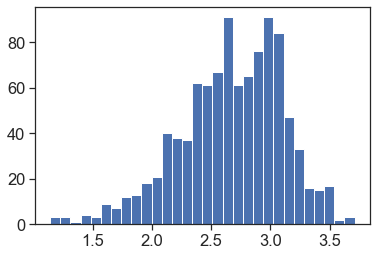

In [249]:
plt.hist(rmse_store,bins=30)

In [179]:
#If you want to see why  a shuffle one did so well use this
y_values = shuffle_store[2]
optimal_params = param_store_store[2]